# Keypoint Detection

First, the reading and video lecture associated with this section:
Szeliski 4.1.  [Mubarak Shah's Lecture on Harris Corner detection](https://www.youtube.com/watch?v=S4mMhuLHrsQ&list=UUlOghZ_xkI1km31IeoY-9Bw).

Now that we have the capabililties in hand to run convolution operations on images, producing outputs that have strong responses to a variety of features (edges, for example), we are in a position to start looking for features in the image that might be good to match.  As it turns out, edges aren't good features to match at all, because they have a tendency to look similar all along the edge.  Instead, it's better to try and match corners.  This is the reasoning behind most keypoint detectors, and most panorama stitching applications work in this way.   

What defines a corner?  A corner is an object where there are big changes to the image no matter which direction we look.  We can reason about whether a given image patch exhibits this property by looking at a so-called *autocorrelation function*:
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [I(\mathbf{u}_i + \Delta \mathbf{u}) - I(\mathbf{u}_i)]^2
$$
where $I$ is image intensity, $\Delta \mathbf{u}$ is a vector of position change, $w$ is an arbitrary kernel, and the summation is over a neighborhood of pixels.  This expression is a little unwieldly.  We can simplify it by approximating the perturbation term with a first order Taylor Series:
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [I(\mathbf{u}_i) + \nabla I(\mathbf{u}_i) \Delta \mathbf{u} - I(\mathbf{u}_i)]^2.
$$
The two intensity terms cancel, and we're left with an expression that only depends on the gradient of the image (which we already know how to calculate).
$$
E_{ac}(\Delta \mathbf{u}) = \sum_{i} w_i [\nabla I(\mathbf{u}_i) \Delta \mathbf{u}]^2 = \Delta \mathbf{u}^T \mathbf{A} \Delta \mathbf{u},
$$
where we can define the (pixel-wise) auto-correlation matrix:
$$
A = \begin{bmatrix} \sum_i w_i \, \partial_u I_i^2 & \sum_i w_i \;\partial_u I_i \;\partial_v I_i \\
                    \sum_i w_i \; \partial_u I_i \; \partial_v I_i & \sum_i w_i \; \partial_v I_i^2 \end{bmatrix}
                                $$
or more concisely as 
$$
A = w \star \begin{bmatrix} \partial_u I^2 & \partial_u I \partial_v I \\
                            \partial_u I \partial_v I & \partial_v I^2 \end{bmatrix}
$$                            
This matrix has all the information about corners that we need in it.  Specifically, it's telling us the way that auto-correlation changes as we move in different directions.  

So given this information, what do we need to know to determine if a particular spot is a corner?  We can determine this by finding the eigenvalues of this matrix, which essentially tells us how much the autocorrelation is changing in the direction of the biggest change (the biggest eigenvalue, which we'll call $\lambda_0$), and also in the direction orthogonal to it (the second eigenvalue $\lambda_1$).  There are three cases that correspond to three possible situations.  First, it could be the case that both $\lambda_0$ and $\lambda_1$ are both very small.  This typically implies that there is not much contrast, and that there is not a corner, or even an edge.  The second case is when $\lambda_0>>\lambda_1$.  This implies that the image is changing alot in one direction, but not much at all in the other direction, which corresponds to an edge.  Finally we have the situation where $\lambda_0$ and $\lambda_1$ are both large and of similar magnitude.  This implies a corner.  The so-called Harris response 
$$h(\mathbf u) = \frac{\lambda_0 \lambda_1}{\lambda_0 + \lambda_1}$$ 
is designed to produce a large value whenever this latter condition is satisfied, and thus will be big for every point that is a corner.  

Note that it would be inefficient to actually form the matrix $A$ and solve for eigenvalues at every point on an image.  Instead we can recognize that both the numerator and the denominator in $h(\mathbf{u}$ are matrix invariants: $\lambda_0 \lambda_1 = \mathrm{Det}(\mathbf{A})$ and $\lambda_0 + \lambda_1 = \mathrm{Tr}(\mathbf{A})$.  Thus we get some pretty easy discrete formulas: 
$$
H = [I_{uu} \circ I_{vv} - I_{uv}\circ I_{uv}] \oslash [I_{uu} + I_{vv}],
$$
where $H$ is the pixel-wise Harris response and 
$$
I_{uu} = w \star [I_u \circ I_u]
$$
$$
I_{vv} = w \star [I_v \circ I_v]
$$
$$
I_{uv} = w \star [I_u \circ I_v]
$$
and $\circ$ and $\oslash$ are elementwise multiplication and division (you will sometimes hear these operations referred to as the Hadamard product and Hadamard division). 

Lastly, we need to make a choice regarding our discrete convolution kernel $w$.  Empirical studies have shown that a good choice is to use a Gaussian kernel with $\sigma=2$.  This effectively smooths the computation of the gradient over several pixels, so that small scale noise in the image does not produce spurious corners.

**Write a function that computes the Harris response over an arbitrary image.  Test this function on two images: first, on the image of a chess-board that is included in this repo.  Second, test it on an image of your choosing.  Does your code produce the expected result of large Harris response at features that could qualitatively be described as corners?**

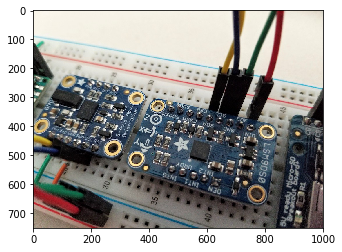

In [525]:
import numpy as np
import matplotlib.pyplot as plt
import numba
#I = plt.imread('chessboard.png')
#I = plt.imread('DanFeedingCows.png')
I = plt.imread('circuit.jpg')
plt.imshow(I,cmap=plt.cm.gray)
plt.show()
I_gray = I.mean(axis=2)
I = I_gray

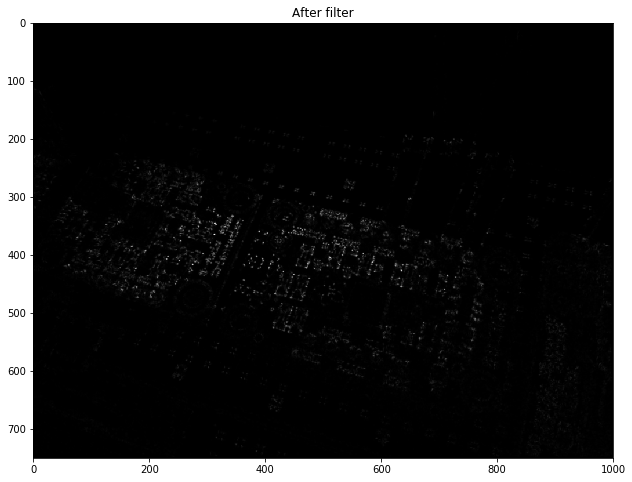

In [526]:
@numba.jit
def convolve(g,h):
    dim = h.shape[0] 
    i = 0
    j = 0
    true_I = np.zeros((g.shape))

    for i in range(0,g.shape[0]-dim): #not sure I'm going far enough

        for j in range (0,g.shape[1]-dim):
            #need to rotate by -180!!!  h[::-1,::-1] for convolution instead 
            #of correlation.  Does not matter for a symmetric matrix in the 
            #first averaging example, but does for Sobel
            
            conv = h[::-1,::-1]*g[i:i+dim,j:j+dim]
            
            filtered_pix = np.sum(conv)

            #finding middle pixel of filter array on image
            #could maybe clean these up with floor division // ?
            fil_pix_col_idx = int(j+((dim-1)/2)) 
            fil_pix_row_idx = int(i+((dim-1)/2))

            true_I[fil_pix_row_idx,fil_pix_col_idx]= filtered_pix

    #edge(edge_type,dim,g,true_I)
    #still need to finish implementing this to clean up the border
    return true_I

def harris(g,w):
    #g is image, w is kernel (Gaussian is good choice)
    sobel_u = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_v = np.transpose(sobel_u)
    I_u = convolve(g,sobel_u)
    I_v = convolve(g,sobel_v)
    Iu_Iu = I_u*I_u
    Iv_Iv = I_v*I_v
    Iu_Iv = I_u*I_v
    I_uu = convolve(Iu_Iu,w)
    I_vv = convolve(Iv_Iv,w)
    I_uv = convolve(Iu_Iv,w)
    
    H = (I_uu*I_vv-I_uv*I_uv)/(I_uu+I_vv+0.0000001) #add small amount to avoid /0
    return H

def gaussian_k(width,sigma):
    
    #gaussian filter kernel width gw
    gw = width
    mu = gw//2 

    sigma = 2 #arbitrary standard deviation
    inside = np.zeros((gw,gw))

    for j in range(0,gw):
        for k in range(0,gw):
            inside[j,k] = np.exp(-((j-mu)**2+(k-mu)**2)/(2*sigma**2))
                        
    gaussian_k = inside/inside.sum()      
    return gaussian_k
########################################################################

H = harris(I,gaussian_k(3,2))

fig, ax = plt.subplots(1, figsize=(12,8))
plt.title("After filter")
ax.imshow(H,cmap=plt.cm.gray)


Ultimately, what we want to do with this is to create a set of discrete points $(u,v)$ that we can match between images.  These points should correspond to local maxima in the Harris response.  **Given a Harris response matrix, write a function that extracts local maxima, and outputs an array of their coordinates**.  This can be done relatively easily via *non-linear* filtering: loop through all of the pixels in the Harris response, and determine if that pixel is the largest in its neighborhood.  If so, then it's a local maximum.  

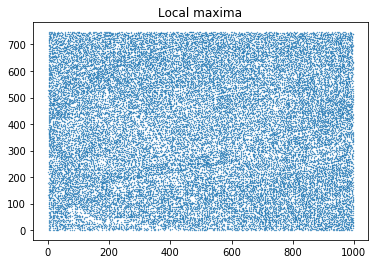

In [527]:
def local_maxima(H,n):
    #n is neighborhood size, ie n x n array neighborhood
    #assume n = 3 - WHY?
    maxima_list = []
    mask = np.ones((3,3),dtype=bool) #thanks Fred!
    #print (H.shape)
    mask[1,1]=False

    for i in range(1,(H.shape[0]-n)):
        for j in range(1,(H.shape[1]-n)):
            p = H[i,j]

            neighbors= H[i-1:i+2,j-1:j+2][mask]  #all values except the center one
            #don't want to compare to itself!
            
            if (p > neighbors).all():

                maxima_list.append((i,j,p))

    #print (neighbors)   
    return maxima_list
                                   

local_max = local_maxima(H,3)

maxima_arr = np.array(local_max)


plt.title("Local maxima")

plt.scatter(maxima_arr[:,1],maxima_arr[:,0],s=0.1)



In [528]:
test = np.array([[0,1,3],[23,3,4],[26,36,1]])
print (test)
#mask = np.ones((3,3),dtype=bool)
#mask[1,1]=False

#print (test[:][mask])
a = test[test[:,2].argsort()]
#a = np.sort(test)

print (a)




[[ 0  1  3]
 [23  3  4]
 [26 36  1]]
[[26 36  1]
 [ 0  1  3]
 [23  3  4]]


## Non-maximal suppression:
For natural images, you're going to end up with a whole bunch of corners.  We'll want to pare that list down by a substantial amount.  One common approach is to only keep the local maxima that are in the top 5% or 10% as determined by their Harris response strength, or are the top $n$ points as measured by Harris response.  **Write some code that keeps the top $n=100$ local maxima.  Overlay these points on a natural image from which they were computed (don't use the checkerboard).  What is their spatial distribution?**

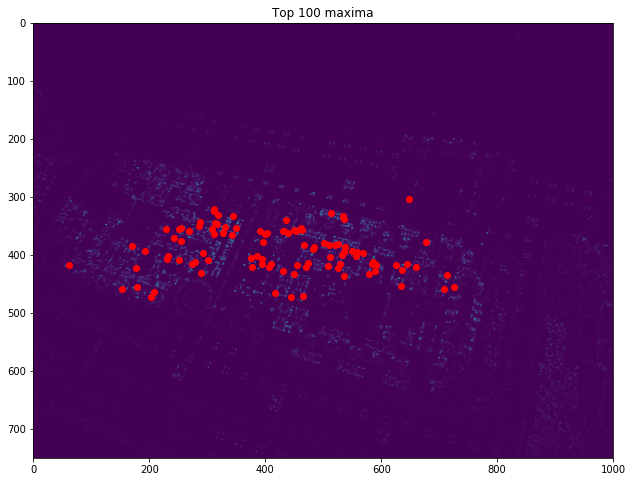

In [529]:
def top_maxima(maxima_arr):
    maxima_asc = maxima_arr[maxima_arr[:,2].argsort()]#https://gist.github.com/stevenvo/e3dad127598842459b68

    maxima_desc = maxima_asc[::-1]


    return maxima_desc[0:100]



top100 = top_maxima(maxima_arr)


fig, ax = plt.subplots(1, figsize=(12,8))
plt.title("Top 100 maxima")
ax.imshow(H)
ax.scatter(top100[:,1],top100[:,0],c="red")


As you've seen above, an unfortunate side-effect of the Harris detector is that keypoints tend to get clustered in regions of high spatial texture.  Since our ultimate goal is to match these keypoints to those in a second image, then warp that image to the same spatial coordinate system as this one, this non-uniform spatial distribution is somewhat undesirable.  In [this paper](MOPS.pdf), the authors outline a strategy for how to find points that are more spatially uniform, which they call *Adaptive Non-maximal Suppression*.  The procedure is simple: for each potential keypoint, find the distance to the nearest potential keypoint with a larger Harris response.  (Note that in practice, we look for the nearest potential keypoint whose Harris response multiplied by a constant $c$ is greater.  The value of $c$ is usually 0.9).  Then sort the list by this distance (in descending order), and keep the top $n$ points in the list, where $n$ is the number of keypoints that we want to maintain.  **Program this adaptive non-maximal suppression algorithm, and plot the top $n=100$ keypoints on the same image as before.  Does this improve the uniformity of the spatial distribution of points?**  

In [530]:
#help from the Jake VDP Data Science book
#k-nearest neighbors example, Ch 2
#%timeit function call

#Do an example first so I can understand how it works

X = np.random.randint(0,100,(5,2))
print(X)
#plt.scatter(X[:,0],X[:,1])



[[66 86]
 [89 88]
 [ 8 14]
 [55 82]
 [70 79]]


Now compute the distance between each pair of points.  The squared distance between
two points is the sum of the squared difference in each dimension (Pythogorean theorem)

Using broadcasting and aggregation


In [531]:
diff1 = X[:,np.newaxis,:]

diff2 = X[np.newaxis,:,:]

#for ecah pair of points, compute difference in their coordinates
differences = diff1-diff2

differences.shape


#square the coordinate differences
sq_diff = differences**2
print (sq_diff.shape)

#sum the coordinate differences to get the squared distance (hypotenuse of triangle)
dist_sq = sq_diff.sum(-1) #don't know why -1

print (dist_sq)

(5, 5, 2)
[[    0   533  8548   137    65]
 [  533     0 12037  1192   442]
 [ 8548 12037     0  6833  8069]
 [  137  1192  6833     0   234]
 [   65   442  8069   234     0]]


In [532]:
#argsort returns the indices of the sorted elements.
#the first element gives the index of the smallest element.  The second
#value gives the index of the second smallest, etc
nearest = np.argsort(dist_sq, axis=1) #axis=1, across columns (gives rows)
print (nearest)

#now sort dist_sq array based on nearest

#print (dist_sq[nearest]) #this is sorting column 0, creating an array element, then
#sorting column 1, creating another array element, etc. not what I want
#print (dist_sq[nearest==1]) #outputs an array with the square distances of the nearest neighbor

#now how do we get back to the nearest neighbor in X array?
#is the column index the nearest point?  For example in 0 2 1 4 3, is point 2 the closest?
nearest_point_index = nearest[nearest==1] #nope
#print (nearest_point_index)                            

nearest_pt_list=[]
for i in range(nearest.shape[0]):
    for j in range (nearest.shape[1]):
        if nearest[i,j]==1:
            nearest_pt_list.append(X[j])
            
print (nearest_pt_list)


[[0 4 3 1 2]
 [1 4 0 3 2]
 [2 3 4 0 1]
 [3 0 4 1 2]
 [4 0 3 1 2]]
[array([55, 82]), array([66, 86]), array([70, 79]), array([55, 82]), array([55, 82])]


In [537]:
#In the interest of time, Fred suggested I just use/modify his working code as long 
#as I understand the algorithm, which I do. Sad to give up, but have spent too much
#time on what I've done so far

def anms(maxima):
    #n=100, c=0.9, use_thresh=True
    use_thresh=True
    if use_thresh:
        thresh = H.mean() + H.std()
    else:
        thresh = H.min()
    #maxima = top_maxima(H)

   
    rmax = np.max(H.shape)**2
    anms_maxima = []
    for i, (u, v, h) in enumerate(maxima):
        rmin = rmax
        for k, (uu, vv, hh) in enumerate(maxima):
            d = np.sqrt((u - uu)**2 + (v - vv)**2)
            if i != k and (h < c * hh) and (d < rmin):
                rmin = d
        anms_maxima.append((u, v, rmin))
    anms_maxima.sort(key=lambda v: v[2], reverse=True)
    return anms_maxima[:n]


In [538]:

points = anms(maxima_arr)
#imshow(Inat, show=False)
#plt.scatter([pi[0] for pi in points], [pi[1] for pi in points], color='r', s=20)
#plt.show()


fig, ax = plt.subplots(1, figsize=(12,8))
plt.title("Adaptive Non-Maximal Supression")
ax.imshow(H)
ax.scatter(points[:,1],points[:,0],c="red")

ValueError: too many values to unpack (expected 3)